# โมเดลทำนายโรคหัวใจ (Heart Disease Prediction Models)

โน้ตบุ๊กนี้ใช้สำหรับฝึกและประเมินโมเดลหลายประเภทเพื่อทำนายโรคหัวใจ โดยใช้ข้อมูลที่ผ่านการ impute ค่าที่หายไปแล้ว

## โครงสร้างของโน้ตบุ๊ก

1. การตั้งค่าเริ่มต้น
   - Import libraries
   - โหลดข้อมูล train/test
   - สร้างโฟลเดอร์สำหรับเก็บโมเดล
   - กำหนดค่าพารามิเตอร์ (n_runs, etc.)

2. ฟังก์ชันสนับสนุน
   - log_final_run_metrics: คำนวณและแสดงผลการประเมินโมเดล
   - save_run_metrics: บันทึกผลลัพธ์แต่ละรัน
   - save_model: บันทึกโมเดลลงไฟล์

3. การฝึกโมเดล (n_runs=5 รอบต่อโมเดล)
   - Logistic Regression
   - Random Forest (พร้อม feature importance)
   - EBM (Explainable Boosting Machine)
   - SVM (Support Vector Machine)
   - XGBoost (พร้อม bootstrap และ feature importance)
   - DNN (Deep Neural Network)

4. การรวมโมเดล (Model Combination)
   - โหลดโมเดลที่บันทึกไว้
   - Ensemble แบบ average probabilities
   - Ensemble แบบ majority vote
   - Stacking meta-learner (OOF)

# Train / Test models (from preprocessed imput data)
ในเซลล์ถัดไปจะมีการนำเข้าไลบรารีที่จำเป็น ฟังก์ชันวัดผล แล้วโหลดไฟล์ train/test ที่เราเซฟไว้ก่อนหน้า จากนั้นจะฝึกโมเดลหลายตัว (n_runs = 5)

## 1. การตั้งค่าเริ่มต้น (Setup)

### 1.1 Import Libraries
นำเข้าไลบรารีที่จำเป็นสำหรับการสร้างและประเมินโมเดล:
- pandas, numpy: สำหรับจัดการข้อมูล
- matplotlib, seaborn: สำหรับการพล็อตกราฟ
- sklearn: สำหรับโมเดล ML พื้นฐาน
- interpret: สำหรับ EBM
- xgboost: สำหรับ XGBoost
- keras: สำหรับ Deep Neural Network
- joblib: สำหรับบันทึก/โหลดโมเดล

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss, brier_score_loss, precision_recall_curve, average_precision_score, f1_score, matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score, hamming_loss, zero_one_loss)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# Keras (DNN)
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

### 1.2 โหลดข้อมูล (Load Data)
โหลดข้อมูล train และ test ที่ผ่านการ preprocess และ impute ค่าที่หายไปแล้ว จากไฟล์ CSV

In [2]:
# โหลด train/test CSV ที่เราเซฟไว้ก่อนหน้า
train_path = '/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/data/heart_disease_preprocessed_imput_train.csv'
test_path  = '/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/data/heart_disease_preprocessed_imput_test.csv'

# ถ้าไฟล์ชื่ออื่น ให้แก้ path ข้างบน

data_train = pd.read_csv(train_path)
data_test  = pd.read_csv(test_path)

### 1.3 สร้างโฟลเดอร์สำหรับโมเดล (Create Model Directory)
สร้างโฟลเดอร์ `model/imput` สำหรับเก็บโมเดลที่ฝึกแล้ว (.joblib สำหรับโมเดล sklearn และ .h5 สำหรับ DNN)

In [3]:
# Create directories for models and results
base_path = '/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original'
model_dir = os.path.join(base_path, 'model', 'imput')
os.makedirs(model_dir, exist_ok=True)
print(f'Created model directory: {model_dir}')

Created model directory: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/model/imput


### 1.4 ตั้งค่าพารามิเตอร์ (Settings)
- n_runs = 5: จำนวนรอบการฝึกต่อโมเดล เพื่อดูความผันแปรของผลลัพธ์
- results: dictionary เก็บ accuracy ของแต่ละรัน
- roc_data: dictionary เก็บข้อมูลสำหรับพล็อต ROC curves

In [4]:
# Settings
n_runs = 5
results = {
    'Logistic Regression': {'train': [], 'test': []},
    'Random Forest': {'train': [], 'test': []},
    'EBM': {'train': [], 'test': []},
    'SVM': {'train': [], 'test': []},
    'XGBoost': {'train': [], 'test': []},
    'DNN': {'train': [], 'test': []},
}
roc_data = {}

## 2. ฟังก์ชันสนับสนุน (Support Functions)

### 2.1 log_final_run_metrics
ฟังก์ชันสำหรับคำนวณและแสดงผลการประเมินโมเดลโดยละเอียด:
- Accuracy และ Error rate
- Classification Report (precision, recall, f1-score)
- Confusion Matrix
- Sensitivity, Specificity, PPV, NPV
- FPR, FNR, F1, MCC, Cohen's kappa
- Log Loss, Brier score (ถ้ามี probabilities)
- ROC curves (เก็บข้อมูลใน roc_data)

In [5]:
def log_final_run_metrics(model_name, y_true, y_pred, y_prob, roc_data_dict):
    print(f"\n=== Final-Run Metrics: {model_name} ===")
    acc = accuracy_score(y_true, y_pred)
    err_rate = 1.0 - acc
    print(f"Accuracy: {acc:.4f}")
    print(f"Error rate (1-Acc): {err_rate:.4f}")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()
    eps = 1e-12
    sensitivity = tp / (tp + fn + eps)
    specificity = tn / (tn + fp + eps)
    precision_pos = tp / (tp + fp + eps)
    npv = tn / (tn + fn + eps)
    fprate = fp / (fp + tn + eps)
    fnrate = fn / (fn + tp + eps)
    f1 = f1_score(y_true, y_pred)

    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    h_loss = hamming_loss(y_true, y_pred)
    z1_loss = zero_one_loss(y_true, y_pred)

    print(f"Sensitivity (Recall+): {sensitivity:.4f} | Specificity: {specificity:.4f}")
    print(f"Precision (PPV): {precision_pos:.4f} | NPV: {npv:.4f}")
    print(f"FPR: {fprate:.4f} | FNR: {fnrate:.4f} | F1: {f1:.4f}")
    print(f"MCC: {mcc:.4f} | Cohen's kappa: {kappa:.4f} | Balanced Acc: {bal_acc:.4f}")
    print(f"Hamming loss: {h_loss:.4f} | Zero-One loss: {z1_loss:.4f}")

    if y_prob is not None:
        try:
            ll = log_loss(y_true, y_prob)
            brier = brier_score_loss(y_true, y_prob)
            prec, rec, _ = precision_recall_curve(y_true, y_prob)
            ap = average_precision_score(y_true, y_prob)

            print(f"Log Loss: {ll:.4f} | Brier score: {brier:.4f}")
            print(f"Average Precision (PR-AUC): {ap:.4f}")

            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            roc_data_dict[model_name] = (fpr, tpr, roc_auc)
        except ValueError:
            print("ข้าม LogLoss/Brier/PR-AUC/ROC: โปรดตรวจว่า y_prob เป็น probability ของคลาส 1")

    return {
        'accuracy': acc,
        'error_rate': err_rate,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pos': precision_pos,
        'npv': npv,
        'fpr': fprate,
        'fnr': fnrate,
        'f1': f1,
        'mcc': mcc,
        'kappa': kappa,
        'balanced_accuracy': bal_acc,
    }

### 2.2 save_run_metrics
ฟังก์ชันสำหรับบันทึกผลลัพธ์ของแต่ละรันลงใน list `detailed_metrics` เพื่อวิเคราะห์ความผันแปรระหว่างรัน

In [6]:
# Initialize detailed metrics DataFrame
detailed_metrics = []

def save_run_metrics(model_name, run, metrics, is_final=False):
    """Save metrics for each run to the detailed_metrics list"""
    run_data = {
        'model': model_name,
        'run': run,
        'is_final': is_final,
        **metrics
    }
    detailed_metrics.append(run_data)

### 2.3 save_model
ฟังก์ชันสำหรับบันทึกโมเดลลงไฟล์:
- โมเดล sklearn: บันทึกเป็น .joblib
- โมเดล DNN: บันทึกเป็น .h5
ไฟล์จะถูกบันทึกในโฟลเดอร์ `model/imput`

In [7]:
def save_model(model_name, model, is_dnn=False):
    """Save model to disk"""
    if is_dnn:
        model_path = os.path.join(model_dir, f"{model_name.lower().replace(' ', '_')}.h5")
        model.save(model_path)
    else:
        model_path = os.path.join(model_dir, f"{model_name.lower().replace(' ', '_')}.joblib")
        joblib.dump(model, model_path)
    print(f"Saved model: {model_path}")
    return model_path

## 3. เตรียมข้อมูล (Data Preparation)
แยก features (X) และ target (y) สำหรับชุด train และ test

In [8]:
label_col = 'Heart Disease Status'
X_train = data_train.drop(columns=[label_col])
y_train = data_train[label_col]
X_test  = data_test.drop(columns=[label_col])
y_test  = data_test[label_col]

print('Loaded train:', data_train.shape, ' test:', data_test.shape)
print('Train label counts:\n', y_train.value_counts())
print('Test label counts:\n', y_test.value_counts())

Loaded train: (8000, 28)  test: (2000, 28)
Train label counts:
 Heart Disease Status
0    6400
1    1600
Name: count, dtype: int64
Test label counts:
 Heart Disease Status
0    1600
1     400
Name: count, dtype: int64


## 4. การฝึกโมเดล (Model Training)

### 4.1 Logistic Regression
โมเดลพื้นฐานที่ใช้เป็น baseline:
- ฝึก n_runs=5 รอบด้วย random_state ต่างกัน
- เก็บ confusion matrices และ classification reports ทุกรัน
- แสดง heatmap ของ confusion matrix ทุกรัน
- บันทึกโมเดลสุดท้ายเป็น `logistic_regression.joblib`


=== Training Logistic Regression ===

--- Run 1/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 2/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 3/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 4/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 5/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

=== Final-Run Metrics: Logistic Regression ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0

/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

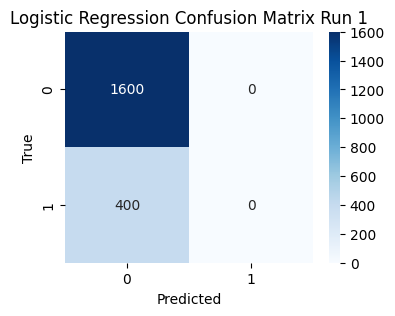

Logistic Regression Classification Report Run 1
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


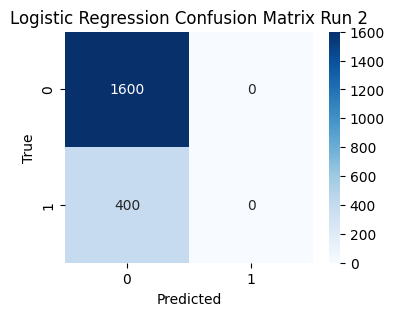

Logistic Regression Classification Report Run 2
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


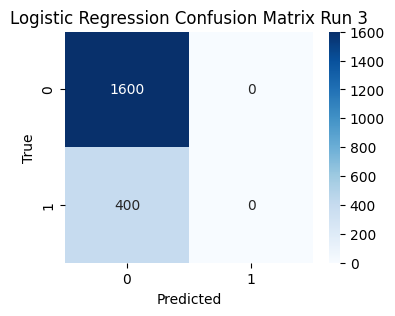

Logistic Regression Classification Report Run 3
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


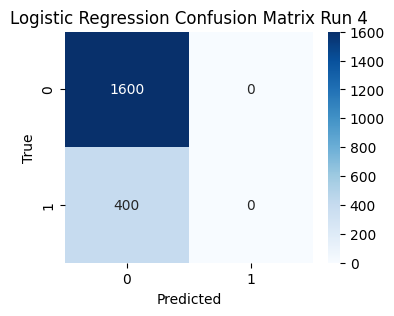

Logistic Regression Classification Report Run 4
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


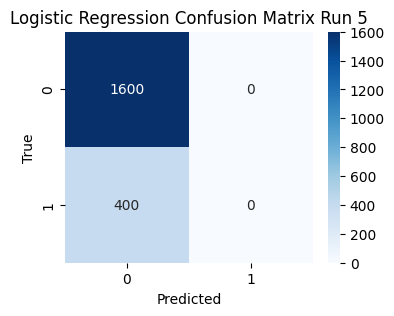

Logistic Regression Classification Report Run 5
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


In [9]:
# 1. Logistic Regression
print("\n=== Training Logistic Regression ===")
lr_cms = []
lr_reports = []
for i in range(n_runs):
    print(f"\n--- Run {i+1}/{n_runs} ---")
    lr = LogisticRegression(max_iter=1000, random_state=i)
    lr.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    y_test_prob = lr.predict_proba(X_test)[:, 1]
    
    # Basic metrics
    tr_acc = accuracy_score(y_train, y_train_pred)
    te_acc = accuracy_score(y_test, y_test_pred)
    results['Logistic Regression']['train'].append(tr_acc)
    results['Logistic Regression']['test'].append(te_acc)
    print(f"Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    
    # Collect confusion matrix and classification report for each run
    lr_cms.append(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
    lr_reports.append(classification_report(y_test, y_test_pred, digits=4, output_dict=True))
    
    # Final run - save model and detailed metrics
    if i == n_runs - 1:
        metrics = log_final_run_metrics('Logistic Regression', y_test, y_test_pred, y_test_prob, roc_data)
        save_run_metrics('Logistic Regression', i, metrics, is_final=True)
        save_model('Logistic Regression', lr)
        # Show all confusion matrices and classification reports
        for j, cm in enumerate(lr_cms):
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f'Logistic Regression Confusion Matrix Run {j+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            print(f'Logistic Regression Classification Report Run {j+1}')
            print(pd.DataFrame(lr_reports[j]).T)

### 4.2 Random Forest
โมเดล ensemble ที่ใช้หลาย decision trees:
- n_estimators=100 trees ต่อ forest
- ฝึก n_runs=5 รอบด้วย random_state ต่างกัน
- แสดง feature importance plot
- บันทึกโมเดลสุดท้ายเป็น `random_forest.joblib`


=== Training Random Forest ===

--- Run 1/5 ---
Train Acc: 1.0000 | Test Acc: 0.8000

--- Run 2/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 1.0000 | Test Acc: 0.8000

--- Run 3/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 1.0000 | Test Acc: 0.8000

--- Run 4/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 1.0000 | Test Acc: 0.8000

--- Run 5/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 1.0000 | Test Acc: 0.8000

=== Final-Run Metrics: Random Forest ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5071 | Brier score: 0.1627
Average Precision (PR-AUC): 0.2082
Saved model: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/model/imput/random_forest.joblib


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

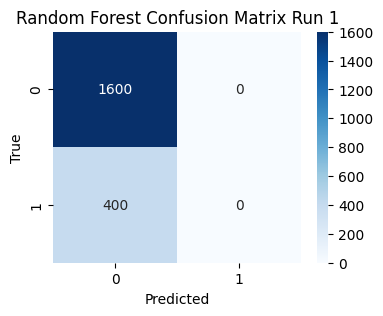

Random Forest Classification Report Run 1
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


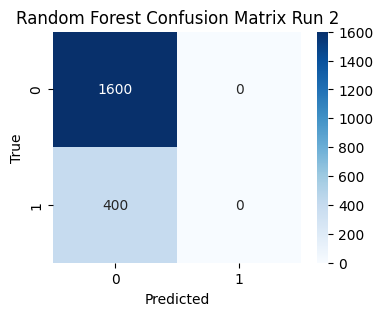

Random Forest Classification Report Run 2
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


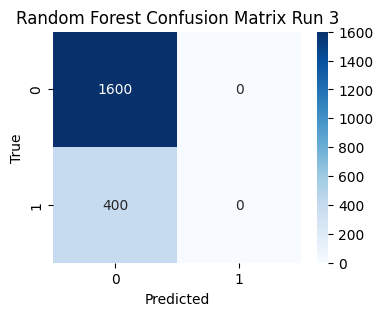

Random Forest Classification Report Run 3
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


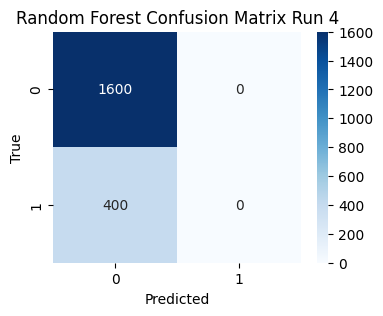

Random Forest Classification Report Run 4
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


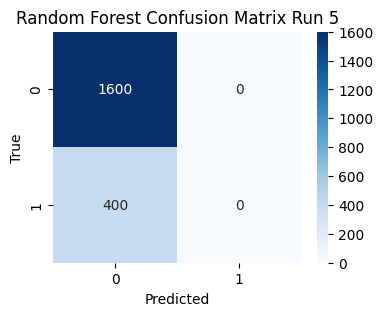

Random Forest Classification Report Run 5
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


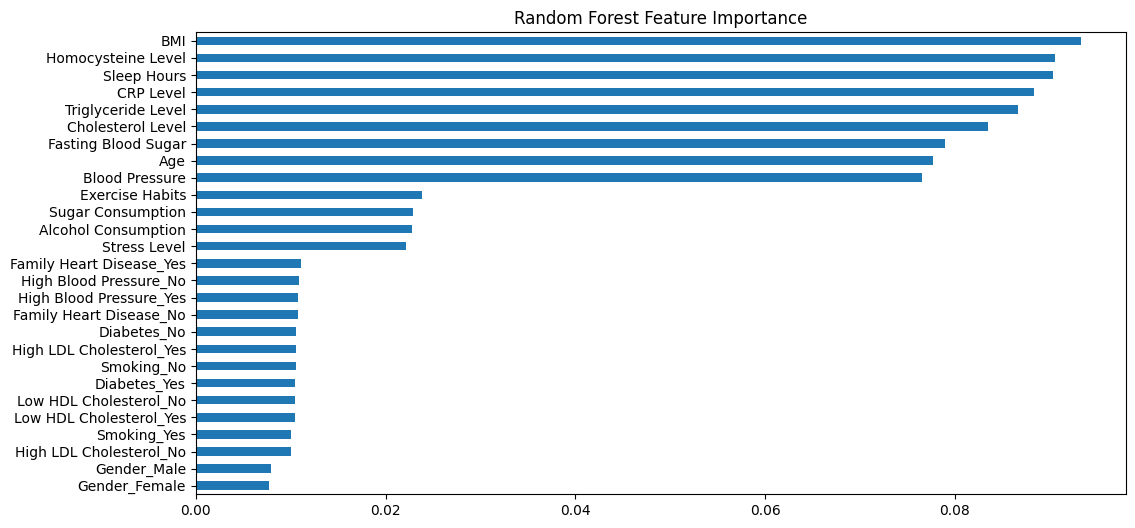

In [10]:
# 2. Random Forest
print("\n=== Training Random Forest ===")
rf_cms = []
rf_reports = []
for i in range(n_runs):
    print(f"\n--- Run {i+1}/{n_runs} ---")
    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    y_test_prob = rf.predict_proba(X_test)[:, 1]
    
    # Basic metrics
    tr_acc = accuracy_score(y_train, y_train_pred)
    te_acc = accuracy_score(y_test, y_test_pred)
    results['Random Forest']['train'].append(tr_acc)
    results['Random Forest']['test'].append(te_acc)
    print(f"Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    
    # Collect confusion matrix and classification report for each run
    rf_cms.append(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
    rf_reports.append(classification_report(y_test, y_test_pred, digits=4, output_dict=True))
    
    # Final run - save model and detailed metrics
    if i == n_runs - 1:
        metrics = log_final_run_metrics('Random Forest', y_test, y_test_pred, y_test_prob, roc_data)
        save_run_metrics('Random Forest', i, metrics, is_final=True)
        save_model('Random Forest', rf)
        # Show all confusion matrices and classification reports
        for j, cm in enumerate(rf_cms):
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f'Random Forest Confusion Matrix Run {j+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            print(f'Random Forest Classification Report Run {j+1}')
            print(pd.DataFrame(rf_reports[j]).T)

# Feature importance plot for Random Forest
if 'rf' in locals():
    plt.figure(figsize=(12, 6))
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    importances.plot(kind='barh')
    plt.title('Random Forest Feature Importance')
    plt.show()

### 4.3 EBM (Explainable Boosting Machine)
โมเดลที่ให้ความสำคัญกับการอธิบายได้:
- แสดง feature importance scores
- แสดง top 5 features ที่สำคัญที่สุด
- บันทึกโมเดลสุดท้ายเป็น `ebm.joblib`


=== Training EBM ===

--- Run 1/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 2/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 3/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 4/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 5/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

=== Final-Run Metrics: EBM ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5020 | Brier score: 0.1605
Average Precision (PR-AUC): 0.1831
Saved model: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/model/imput/ebm.joblib


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

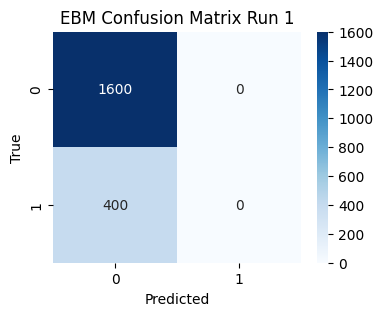

EBM Classification Report Run 1
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


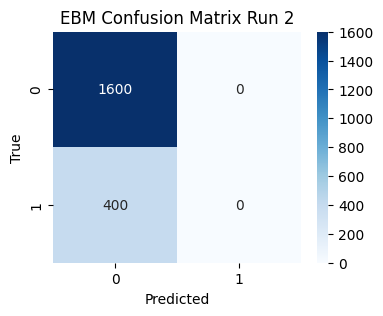

EBM Classification Report Run 2
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


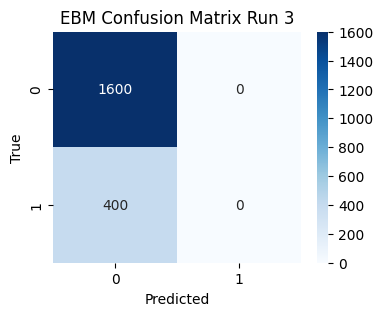

EBM Classification Report Run 3
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


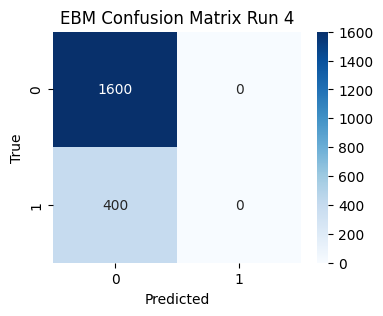

EBM Classification Report Run 4
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


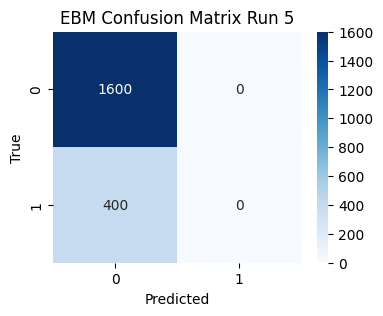

EBM Classification Report Run 5
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0

Top 5 most important features (EBM):
1. Gender_Male: 0.0096
2. Gender_Female: 0.0095
3. Smoking_No: 0.0031
4. Smoking_Yes: 0.0031
5. Family Heart Disease_No: 0.0019


In [11]:
# 3. EBM (ExplainableBoostingClassifier)
print("\n=== Training EBM ===")
ebm_cms = []
ebm_reports = []
for i in range(n_runs):
    print(f"\n--- Run {i+1}/{n_runs} ---")
    ebm = ExplainableBoostingClassifier(random_state=i)
    ebm.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = ebm.predict(X_train)
    y_test_pred = ebm.predict(X_test)
    y_test_prob = ebm.predict_proba(X_test)[:, 1]
    
    # Basic metrics
    tr_acc = accuracy_score(y_train, y_train_pred)
    te_acc = accuracy_score(y_test, y_test_pred)
    results['EBM']['train'].append(tr_acc)
    results['EBM']['test'].append(te_acc)
    print(f"Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    
    # Collect confusion matrix and classification report for each run
    ebm_cms.append(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
    ebm_reports.append(classification_report(y_test, y_test_pred, digits=4, output_dict=True))
    
    # Final run - save model and detailed metrics
    if i == n_runs - 1:
        metrics = log_final_run_metrics('EBM', y_test, y_test_pred, y_test_prob, roc_data)
        save_run_metrics('EBM', i, metrics, is_final=True)
        save_model('EBM', ebm)
        # Show all confusion matrices and classification reports
        for j, cm in enumerate(ebm_cms):
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f'EBM Confusion Matrix Run {j+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            print(f'EBM Classification Report Run {j+1}')
            print(pd.DataFrame(ebm_reports[j]).T)
        # Global explanation for EBM
        print("\nTop 5 most important features (EBM):")
        global_explanation = ebm.explain_global()
        scores = global_explanation.data()['scores']
        for k, name in enumerate(global_explanation.feature_names[:5]):
            print(f"{k+1}. {name}: {scores[k]:.4f}")

### 4.4 SVM (Support Vector Machine)
โมเดลที่ใช้ kernel trick เพื่อจัดการข้อมูลไม่เชิงเส้น:
- ใช้ RBF kernel
- probability=True เพื่อให้ได้ probability estimates
- บันทึกโมเดลสุดท้ายเป็น `svm.joblib`


=== Training SVM ===

--- Run 1/5 ---
Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 2/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 3/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 4/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

--- Run 5/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

Train Acc: 0.8000 | Test Acc: 0.8000

=== Final-Run Metrics: SVM ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5006 | Brier score: 0.1601
Average Precision (PR-AUC): 0.1893
Saved model: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/model/imput/svm.joblib


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

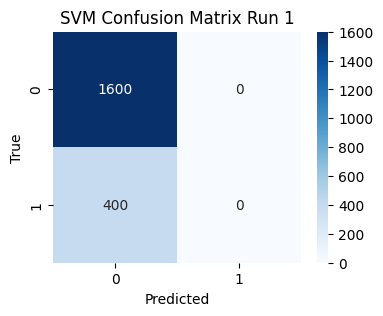

SVM Classification Report Run 1
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


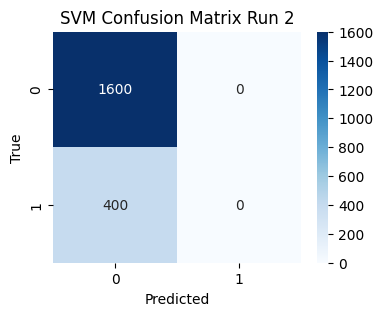

SVM Classification Report Run 2
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


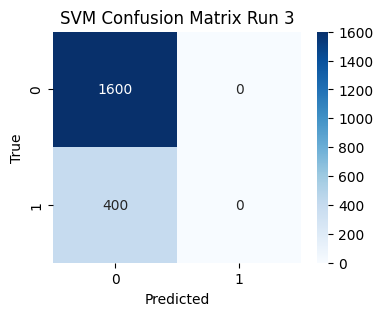

SVM Classification Report Run 3
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


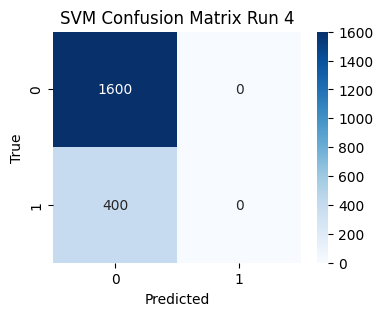

SVM Classification Report Run 4
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


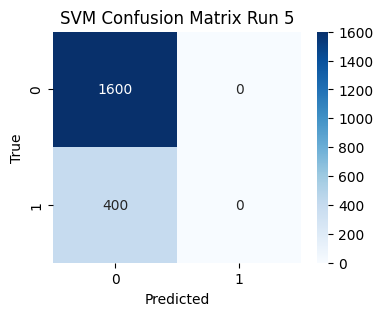

SVM Classification Report Run 5
              precision  recall  f1-score  support
0                  0.80     1.0  0.888889   1600.0
1                  0.00     0.0  0.000000    400.0
accuracy           0.80     0.8  0.800000      0.8
macro avg          0.40     0.5  0.444444   2000.0
weighted avg       0.64     0.8  0.711111   2000.0


In [12]:
# 4. SVM
print("\n=== Training SVM ===")
svm_cms = []
svm_reports = []
for i in range(n_runs):
    print(f"\n--- Run {i+1}/{n_runs} ---")
    svm = SVC(kernel='rbf', probability=True, random_state=i)
    svm.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)
    y_test_prob = svm.predict_proba(X_test)[:, 1]
    
    # Basic metrics
    tr_acc = accuracy_score(y_train, y_train_pred)
    te_acc = accuracy_score(y_test, y_test_pred)
    results['SVM']['train'].append(tr_acc)
    results['SVM']['test'].append(te_acc)
    print(f"Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    
    # Collect confusion matrix and classification report for each run
    svm_cms.append(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
    svm_reports.append(classification_report(y_test, y_test_pred, digits=4, output_dict=True))
    
    # Final run - save model and detailed metrics
    if i == n_runs - 1:
        metrics = log_final_run_metrics('SVM', y_test, y_test_pred, y_test_prob, roc_data)
        save_run_metrics('SVM', i, metrics, is_final=True)
        save_model('SVM', svm)
        # Show all confusion matrices and classification reports
        for j, cm in enumerate(svm_cms):
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f'SVM Confusion Matrix Run {j+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            print(f'SVM Classification Report Run {j+1}')
            print(pd.DataFrame(svm_reports[j]).T)

### 4.5 XGBoost
โมเดล gradient boosting ที่มีประสิทธิภาพสูง:
- ใช้ bootstrap resampling ต่อรัน
- subsample=0.8, colsample_bytree=0.8 เพื่อเพิ่ม randomness
- ตรวจสอบความหลากหลายของ predictions ระหว่างรัน
- แสดง feature importance
- บันทึกโมเดลสุดท้ายเป็น `xgboost.joblib`


=== Training XGBoost ===

--- Run 1/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Acc: 0.9091 | Test Acc: 0.7765

--- Run 2/5 ---
Train Acc: 0.9077 | Test Acc: 0.7725

--- Run 3/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Acc: 0.9006 | Test Acc: 0.7655

--- Run 4/5 ---
Train Acc: 0.9087 | Test Acc: 0.7745

--- Run 5/5 ---
Train Acc: 0.9110 | Test Acc: 0.7640

=== Final-Run Metrics: XGBoost ===
Accuracy: 0.7640
Error rate (1-Acc): 0.2360
Classification Report:
              precision    recall  f1-score   support

           0     0.7965    0.9469    0.8652      1600
           1     0.1327    0.0325    0.0522       400

    accuracy                         0.7640      2000
   macro avg     0.4646    0.4897    0.4587      2000
weighted avg     0.6638    0.7640    0.7026      2000

Confusion Matrix [rows=true, cols=pred]:
[[1515   85]
 [ 387   13]]
Sensitivity (Recall+): 0.0325 | Specificity: 0.9469
Precision (PPV): 0.1327 | NPV: 0.7965
FPR: 0.0531 | FNR: 0.9675 | F1: 0.0522
MCC: -0.0382 | Cohen's kappa: -0.0288 | Balanced Acc: 0.4897
Hamming loss: 0.2360 | Zero-One loss: 0.2360
Log Loss: 0.6611 | Brier score: 0.1919
Average Precision (PR-AUC): 0.1905
Saved model: /Users/tanananyathongkum/Jenny/Visu

/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


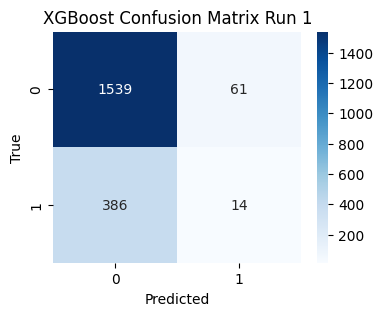

XGBoost Classification Report Run 1
              precision    recall  f1-score    support
0              0.799481  0.961875  0.873191  1600.0000
1              0.186667  0.035000  0.058947   400.0000
accuracy       0.776500  0.776500  0.776500     0.7765
macro avg      0.493074  0.498438  0.466069  2000.0000
weighted avg   0.676918  0.776500  0.710343  2000.0000


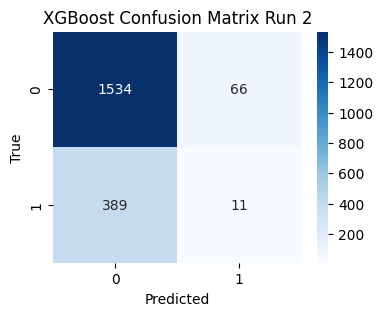

XGBoost Classification Report Run 2
              precision    recall  f1-score    support
0              0.797712  0.958750  0.870849  1600.0000
1              0.142857  0.027500  0.046122   400.0000
accuracy       0.772500  0.772500  0.772500     0.7725
macro avg      0.470285  0.493125  0.458485  2000.0000
weighted avg   0.666741  0.772500  0.705903  2000.0000


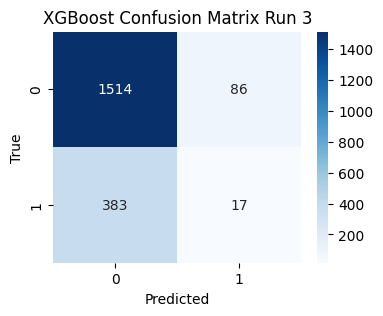

XGBoost Classification Report Run 3
              precision    recall  f1-score    support
0              0.798102  0.946250  0.865885  1600.0000
1              0.165049  0.042500  0.067594   400.0000
accuracy       0.765500  0.765500  0.765500     0.7655
macro avg      0.481575  0.494375  0.466740  2000.0000
weighted avg   0.671492  0.765500  0.706227  2000.0000


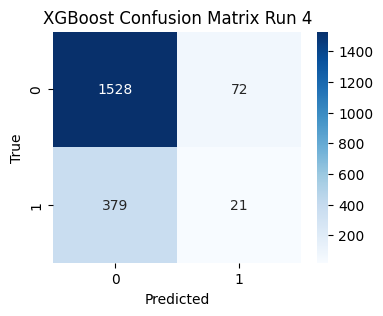

XGBoost Classification Report Run 4
              precision   recall  f1-score    support
0              0.801259  0.95500  0.871400  1600.0000
1              0.225806  0.05250  0.085193   400.0000
accuracy       0.774500  0.77450  0.774500     0.7745
macro avg      0.513532  0.50375  0.478296  2000.0000
weighted avg   0.686168  0.77450  0.714159  2000.0000


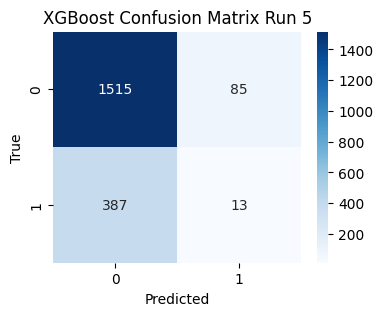

XGBoost Classification Report Run 5
              precision    recall  f1-score   support
0              0.796530  0.946875  0.865220  1600.000
1              0.132653  0.032500  0.052209   400.000
accuracy       0.764000  0.764000  0.764000     0.764
macro avg      0.464592  0.489687  0.458714  2000.000
weighted avg   0.663755  0.764000  0.702618  2000.000

XGBoost predictions unique count across 5 runs: 5
XGBoost predictions vary across runs (good).


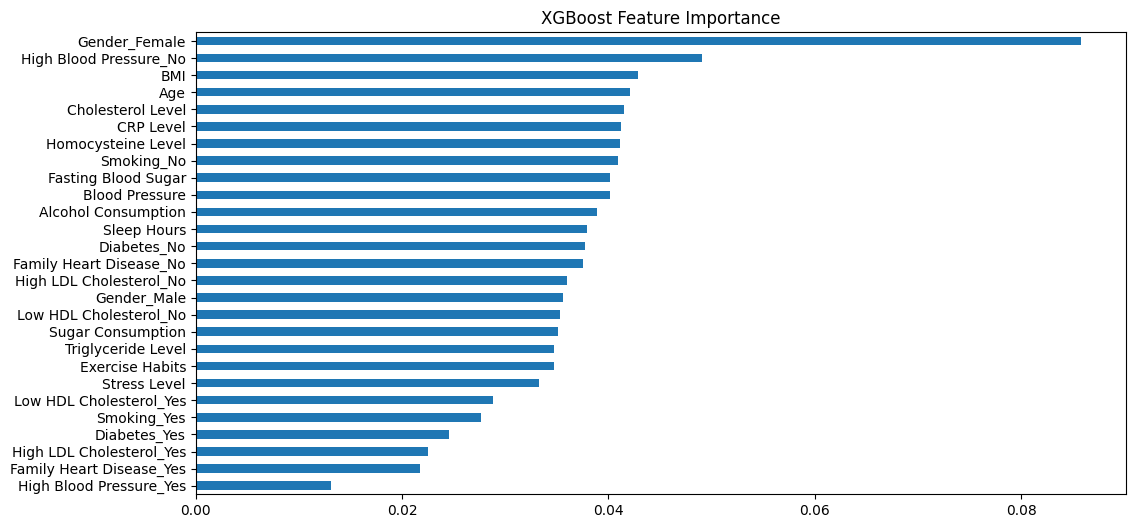

In [13]:
# 5. XGBoost
print("\n=== Training XGBoost ===")
xgb_cms = []
xgb_reports = []
xgb_preds = []
for i in range(n_runs):
    print(f"\n--- Run {i+1}/{n_runs} ---")
    # Bootstrap the training set each run to introduce variability
    X_train_boot, y_train_boot = resample(X_train, y_train, replace=True, n_samples=len(X_train), random_state=i)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i, subsample=0.8, colsample_bytree=0.8)
    xgb.fit(X_train_boot, y_train_boot)
    
    # Predictions
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
    # Some xgboost versions may not provide predict_proba in same way; handle robustly
    try:
        y_test_prob = xgb.predict_proba(X_test)[:, 1]
    except Exception:
        y_test_prob = xgb.predict(X_test)  # fallback to labels (will break some prob metrics)
    
    # Basic metrics
    tr_acc = accuracy_score(y_train, y_train_pred)
    te_acc = accuracy_score(y_test, y_test_pred)
    results['XGBoost']['train'].append(tr_acc)
    results['XGBoost']['test'].append(te_acc)
    print(f"Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    
    # Collect confusion matrix, classification report, and preds for each run
    xgb_cms.append(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
    xgb_reports.append(classification_report(y_test, y_test_pred, digits=4, output_dict=True))
    xgb_preds.append(tuple(y_test_pred))
    
    # Final run - save model and detailed metrics
    if i == n_runs - 1:
        metrics = log_final_run_metrics('XGBoost', y_test, y_test_pred, y_test_prob, roc_data)
        save_run_metrics('XGBoost', i, metrics, is_final=True)
        save_model('XGBoost', xgb)
        # Show all confusion matrices and classification reports
        for j, cm in enumerate(xgb_cms):
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f'XGBoost Confusion Matrix Run {j+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            print(f'XGBoost Classification Report Run {j+1}')
            print(pd.DataFrame(xgb_reports[j]).T)
        # Diagnostic: check whether predictions differ across runs
        unique_preds = len(set(xgb_preds))
        print(f"\nXGBoost predictions unique count across {n_runs} runs: {unique_preds}")
        if unique_preds == 1:
            print("Warning: All XGBoost runs produced identical predictions. Consider adding more randomness (subsample, colsample_bytree) or varying hyperparameters or using different bootstrap seeds).")
        else:
            print("XGBoost predictions vary across runs (good).")

# Feature importance plot for XGBoost
if 'xgb' in locals():
    plt.figure(figsize=(12, 6))
    importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    importances.plot(kind='barh')
    plt.title('XGBoost Feature Importance')
    plt.show()

### 4.6 DNN (Deep Neural Network)
โมเดล neural network ด้วย Keras:
- Architecture: 128 -> BatchNorm -> Dropout(0.3) -> 64 -> 1
- Binary crossentropy loss
- Adam optimizer
- 20 epochs ต่อรัน
- แสดง training history (loss/accuracy)
- บันทึกโมเดลสุดท้ายเป็น `dnn.h5`


=== Training DNN ===

--- DNN Run 1/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
Train Acc: 0.8131 | Test Acc: 0.7875

--- DNN Run 2/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
Train Acc: 0.8157 | Test Acc: 0.7835

--- DNN Run 3/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
Train Acc: 0.8125 | Test Acc: 0.7915

--- DNN Run 4/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
Train Acc: 0.8224 | Test Acc: 0.7835

--- DNN Run 5/5 ---


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


Train Acc: 0.8190 | Test Acc: 0.7875

=== Final-Run Metrics: DNN ===
Accuracy: 0.7875
Error rate (1-Acc): 0.2125
Classification Report:
              precision    recall  f1-score   support

           0     0.7990    0.9812    0.8808      1600
           1     0.1429    0.0125    0.0230       400

    accuracy                         0.7875      2000
   macro avg     0.4709    0.4969    0.4519      2000
weighted avg     0.6678    0.7875    0.7092      2000

Confusion Matrix [rows=true, cols=pred]:
[[1570   30]
 [ 395    5]]
Sensitivity (Recall+): 0.0125 | Specificity: 0.9812
Precision (PPV): 0.1429 | NPV: 0.7990
FPR: 0.0187 | FNR: 0.9875 | F1: 0.0230
MCC: -0.0191 | Cohen's kappa: -0.0095 | Balanced Acc: 0.4969
Hamming loss: 0.2125 | Zero-One loss: 0.2125
Log Loss: 0.5346 | Brier score: 0.1707
Average Precision (PR-AUC): 0.2055
Saved model: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/model/imput/dnn.h5


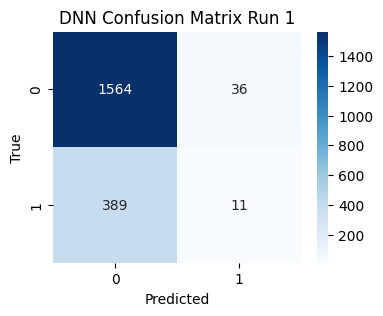

DNN Classification Report Run 1
              precision  recall  f1-score    support
0              0.800819  0.9775  0.880383  1600.0000
1              0.234043  0.0275  0.049217   400.0000
accuracy       0.787500  0.7875  0.787500     0.7875
macro avg      0.517431  0.5025  0.464800  2000.0000
weighted avg   0.687464  0.7875  0.714150  2000.0000


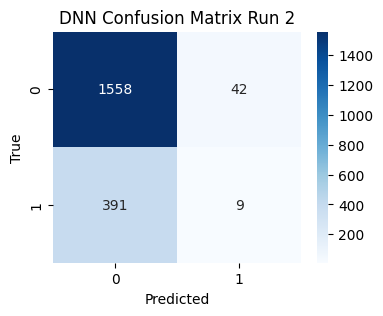

DNN Classification Report Run 2
              precision    recall  f1-score    support
0              0.799384  0.973750  0.877994  1600.0000
1              0.176471  0.022500  0.039911   400.0000
accuracy       0.783500  0.783500  0.783500     0.7835
macro avg      0.487927  0.498125  0.458953  2000.0000
weighted avg   0.674802  0.783500  0.710377  2000.0000


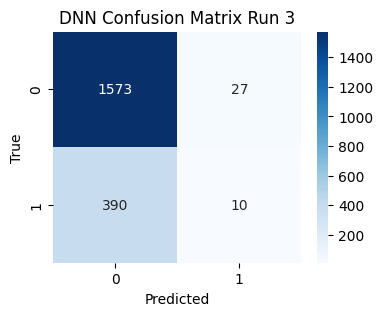

DNN Classification Report Run 3
              precision    recall  f1-score    support
0              0.801325  0.983125  0.882964  1600.0000
1              0.270270  0.025000  0.045767   400.0000
accuracy       0.791500  0.791500  0.791500     0.7915
macro avg      0.535797  0.504062  0.464365  2000.0000
weighted avg   0.695114  0.791500  0.715524  2000.0000


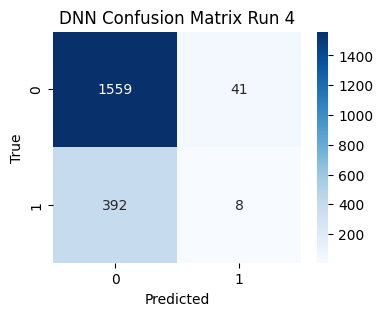

DNN Classification Report Run 4
              precision    recall  f1-score    support
0              0.799077  0.974375  0.878063  1600.0000
1              0.163265  0.020000  0.035635   400.0000
accuracy       0.783500  0.783500  0.783500     0.7835
macro avg      0.481171  0.497188  0.456849  2000.0000
weighted avg   0.671915  0.783500  0.709577  2000.0000


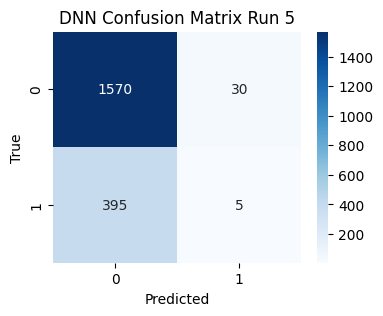

DNN Classification Report Run 5
              precision    recall  f1-score    support
0              0.798982  0.981250  0.880785  1600.0000
1              0.142857  0.012500  0.022989   400.0000
accuracy       0.787500  0.787500  0.787500     0.7875
macro avg      0.470920  0.496875  0.451887  2000.0000
weighted avg   0.667757  0.787500  0.709226  2000.0000


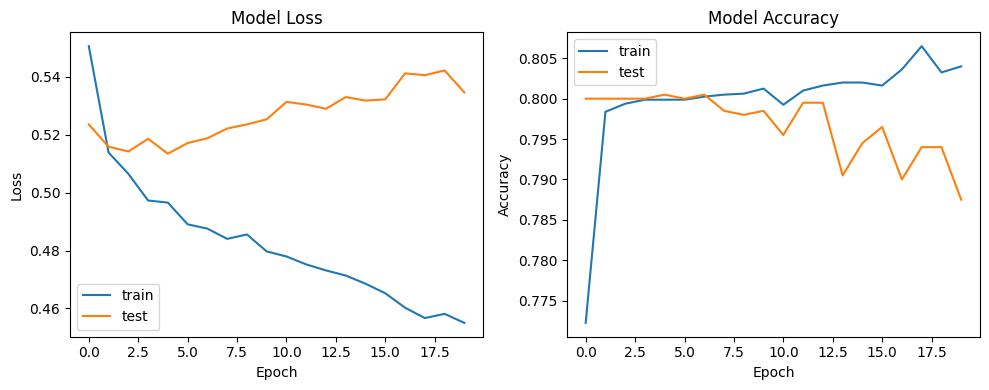

In [14]:
# 6. DNN (Deep Neural Network)
print("\n=== Training DNN ===")
dnn_cms = []
dnn_reports = []
for i in range(n_runs):
    print(f"\n--- DNN Run {i+1}/{n_runs} ---")
    
    # Create and compile model
    dnn = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train model
    history = dnn.fit(X_train, y_train, 
                     epochs=20, 
                     batch_size=32, 
                     verbose=0,
                     validation_data=(X_test, y_test))
    
    # Predictions
    y_train_prob = dnn.predict(X_train).flatten()
    y_train_pred = (y_train_prob > 0.5).astype(int)
    y_test_prob = dnn.predict(X_test).flatten()
    y_test_pred = (y_test_prob > 0.5).astype(int)
    
    # Basic metrics
    tr_acc = accuracy_score(y_train, y_train_pred)
    te_acc = accuracy_score(y_test, y_test_pred)
    results['DNN']['train'].append(tr_acc)
    results['DNN']['test'].append(te_acc)
    print(f"Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    
    # Collect confusion matrix and classification report for each run
    dnn_cms.append(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))
    dnn_reports.append(classification_report(y_test, y_test_pred, digits=4, output_dict=True))
    
    # Final run - save model and detailed metrics
    if i == n_runs - 1:
        metrics = log_final_run_metrics('DNN', y_test, y_test_pred, y_test_prob, roc_data)
        save_run_metrics('DNN', i, metrics, is_final=True)
        save_model('DNN', dnn, is_dnn=True)
        # Show all confusion matrices and classification reports
        for j, cm in enumerate(dnn_cms):
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
            plt.title(f'DNN Confusion Matrix Run {j+1}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
            print(f'DNN Classification Report Run {j+1}')
            print(pd.DataFrame(dnn_reports[j]).T)
        # Plot training history
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='test')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

### 5.2 Ensemble
การรวมผลทำนายจากหลายโมเดล:
1. Average probabilities (soft voting)
   - เฉลี่ย probabilities จากทุกโมเดลที่สามารถให้ probabilities ได้
2. Majority vote (hard voting)
   - ใช้การโหวตเสียงส่วนใหญ่จากผลทำนายของทุกโมเดล
3. ผลลัพธ์:
   - บันทึก summary เป็น `model_results_imput.csv`
   - บันทึก ROC curves เป็น `roc_curves.png`


=== Building ensembles from trained models ===
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
Models available for ensembling: ['Logistic Regression', 'Random Forest', 'EBM', 'SVM', 'XGBoost', 'DNN']

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000



/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

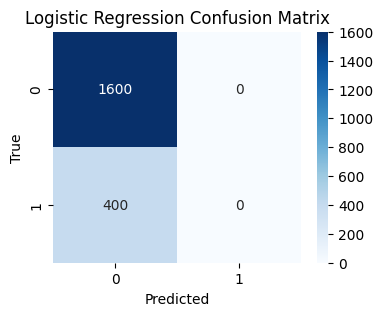


--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000



/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

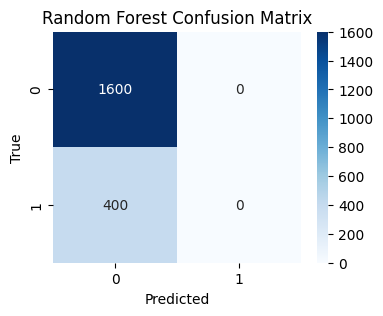


--- EBM ---
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000



/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

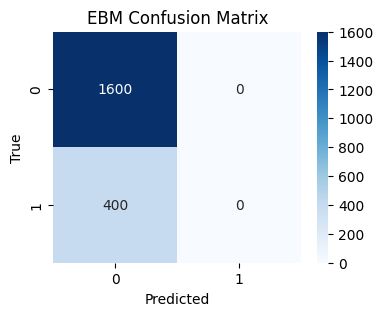


--- SVM ---
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000



/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

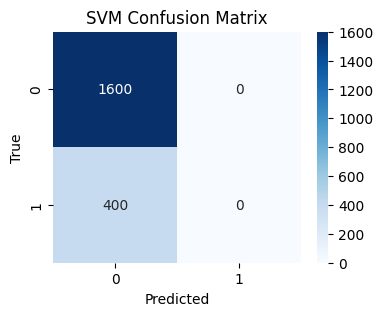


--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0     0.7965    0.9469    0.8652      1600
           1     0.1327    0.0325    0.0522       400

    accuracy                         0.7640      2000
   macro avg     0.4646    0.4897    0.4587      2000
weighted avg     0.6638    0.7640    0.7026      2000



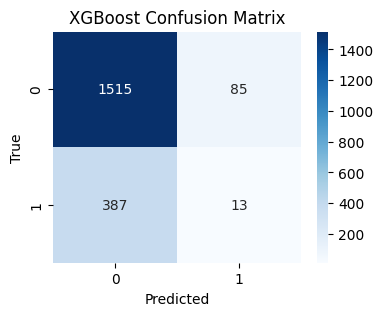


--- DNN ---
Classification Report:
              precision    recall  f1-score   support

           0     0.7990    0.9812    0.8808      1600
           1     0.1429    0.0125    0.0230       400

    accuracy                         0.7875      2000
   macro avg     0.4709    0.4969    0.4519      2000
weighted avg     0.6678    0.7875    0.7092      2000



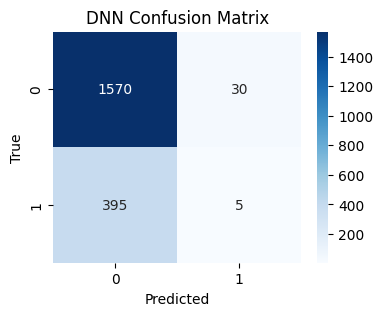


=== Summary (sorted by accuracy) ===


,model,accuracy,f1,roc_auc
0,Logistic Regression,0.8000,0.000000,0.469436
1,Random Forest,0.8000,0.000000,0.528094
2,EBM,0.8000,0.000000,0.469772
3,SVM,0.8000,0.000000,0.483384
4,DNN,0.7875,0.022989,0.514459
5,XGBoost,0.7640,0.052209,0.472500


Saved summary to /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/model_results_imput.csv
Saved ROC plot to /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/codeing/imput/G1_Original/Original/roc_curves.png


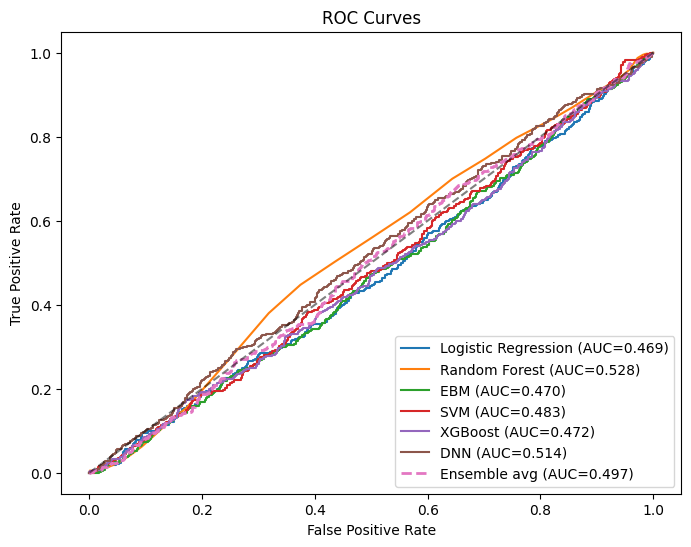

In [15]:
# --- Ensemble: average-probability and majority-vote ---
print("\n=== Building ensembles from trained models ===")
# Auto-load models from disk if missing in memory (helpful after kernel restart)
import joblib
from keras.models import load_model
name_to_file = {
    'Logistic Regression': 'logistic_regression.joblib',
    'Random Forest': 'random_forest.joblib',
    'EBM': 'ebm.joblib',
    'SVM': 'svm.joblib',
    'XGBoost': 'xgboost.joblib',
    'DNN': 'dnn.h5',
}
name_to_var = {
    'Logistic Regression': 'lr',
    'Random Forest': 'rf',
    'EBM': 'ebm',
    'SVM': 'svm',
    'XGBoost': 'xgb',
    'DNN': 'dnn',
}
# try to load any missing models
for name, fname in name_to_file.items():
    var = name_to_var[name]
    if var not in globals():
        path = os.path.join(model_dir, fname)
        if os.path.exists(path):
            try:
                if fname.endswith('.h5'):
                    mdl = load_model(path)
                else:
                    mdl = joblib.load(path)
                globals()[var] = mdl
                print(f"Loaded {name} -> variable '{var}' from {path}")
            except Exception as e:
                print(f"Failed to load {name} from {path}: {e}")
        else:
            print(f"Not found: {path} (will skip or require in-memory model)")

# Collect model probabilities and predictions if available
model_probs = {}  # name -> prob of class 1 (np.array)
model_preds = {}  # name -> predicted labels (np.array)
available_models = []
for name in ['Logistic Regression','Random Forest','EBM','SVM','XGBoost','DNN']:
    var_name = name.lower().replace(' ', '_')
    mapping = {
        'logistic_regression': 'lr',
        'random_forest': 'rf',
        'ebm': 'ebm',
        'svm': 'svm',
        'xgboost': 'xgb',
        'dnn': 'dnn',
    }
    v = mapping.get(var_name)
    if v in globals():
        mdl = globals()[v]
        try:
            prob = mdl.predict_proba(X_test)[:, 1]
            pred = mdl.predict(X_test)
            model_probs[name] = np.asarray(prob)
            model_preds[name] = np.asarray(pred)
            available_models.append(name)
        except Exception:
            try:
                if v == 'dnn':
                    prob = mdl.predict(X_test).flatten()
                    pred = (prob > 0.5).astype(int)
                    model_probs[name] = np.asarray(prob)
                    model_preds[name] = np.asarray(pred)
                    available_models.append(name)
                else:
                    pred = mdl.predict(X_test)
                    model_preds[name] = np.asarray(pred)
                    print(f"Note: {name} has no predict_proba; using labels only for voting.")
                    available_models.append(name)
            except Exception as e:
                print(f"Skipping {name}: error getting preds/probs -> {e}")
    else:
        pass

print(f"Models available for ensembling: {available_models}")

# Build ensemble by averaging probabilities (only models that provide probs)
if len(model_probs) > 0:
    probs_stack = np.vstack(list(model_probs.values()))  # shape: (n_models_with_probs, n_samples)
    avg_prob = probs_stack.mean(axis=0)
    ensemble_avg_pred = (avg_prob > 0.5).astype(int)
else:
    avg_prob = None
    ensemble_avg_pred = None

# Build ensemble by majority vote using available label preds
if len(model_preds) > 0:
    preds_stack = np.vstack(list(model_preds.values()))  # shape: (n_models, n_samples)
    def majority_vote_row(row):
        vals, counts = np.unique(row, return_counts=True)
        return vals[np.argmax(counts)]
    ensemble_vote_pred = np.apply_along_axis(majority_vote_row, 0, preds_stack)
else:
    ensemble_vote_pred = None

# Evaluate ensembles and individual models (summary)
summary = []
def add_summary(name, y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        roc_auc = auc(*roc_curve(y_true, y_prob)[:2]) if y_prob is not None else np.nan
    except Exception:
        roc_auc = np.nan
    summary.append({'model': name, 'accuracy': acc, 'f1': f1, 'roc_auc': roc_auc})

# Individual models (report and confusion matrix)
for name in available_models:
    y_pred = model_preds.get(name)
    y_prob = model_probs.get(name, None)
    print(f"\n--- {name} ---")
    print('Classification Report:')
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    add_summary(name, y_test, y_pred, y_prob)


# Summary table
summary_df = pd.DataFrame(summary).sort_values(by='accuracy', ascending=False).reset_index(drop=True)
print('\n=== Summary (sorted by accuracy) ===')
display(summary_df)
# Save summary CSV
try:
    csv_path = os.path.join(base_path, 'model_results_imput.csv')
    summary_df.to_csv(csv_path, index=False)
    print(f'Saved summary to {csv_path}')
except Exception as e:
    print(f'Could not save summary CSV: {e}')

# ROC curves (for models with probabilities plus avg ensemble)
plt.figure(figsize=(8,6))
plotted = False
for name, prob in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plotted = True
if avg_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, avg_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Ensemble avg (AUC={roc_auc:.3f})", linestyle='--', linewidth=2)
    plotted = True
if plotted:
    plt.plot([0,1],[0,1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    # Save ROC plot
    try:
        roc_path = os.path.join(base_path, 'roc_curves.png')
        plt.savefig(roc_path, dpi=150, bbox_inches='tight')
        print(f'Saved ROC plot to {roc_path}')
    except Exception as e:
        print(f'Could not save ROC plot: {e}')
    plt.show()
else:
    print('No probability outputs available to plot ROC.')

### 5.3 Stacking Meta-learner
การใช้ OOF (Out-of-Fold) predictions เป็น features:
1. สร้าง OOF probabilities จากโมเดลพื้นฐานที่ compatible กับ sklearn
2. ใช้ LogisticRegression เป็น meta-learner
3. ประเมินผลและเพิ่มใน summary
หมายเหตุ: DNN จะถูกข้ามเว้นแต่จะมี wrapper ที่ compatible กับ sklearn


=== Stacking meta-learner (OOF) ===
Base models for stacking: ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'EBM']
Generating OOF for Logistic Regression...
Generating OOF for Random Forest...
Generating OOF for SVM...
Generating OOF for XGBoost...


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:26:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:26:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:26:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/sit

Generating OOF for EBM...

Stacking meta-learner results:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000



/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

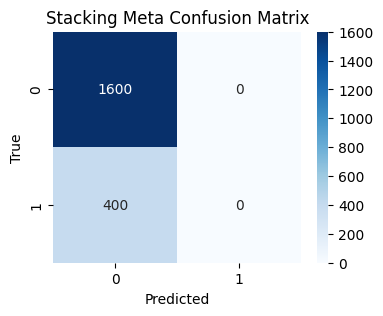


Updated summary including stacking:


,model,accuracy,f1,roc_auc
0,Logistic Regression,0.8000,0.000000,0.469436
1,Random Forest,0.8000,0.000000,0.528094
2,EBM,0.8000,0.000000,0.469772
3,SVM,0.8000,0.000000,0.483384
4,Stacking_meta,0.8000,0.000000,0.468831
5,DNN,0.7875,0.022989,0.514459
6,XGBoost,0.7640,0.052209,0.472500


In [16]:
# --- Stacking meta-learner (OOF stacking) ---
print('\n=== Stacking meta-learner (OOF) ===')
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

# Choose sklearn-compatible base models available in globals
base_model_vars = []
mapping = {'Logistic Regression':'lr','Random Forest':'rf','SVM':'svm','XGBoost':'xgb','EBM':'ebm'}
for name,var in mapping.items():
    if var in globals():
        mdl = globals()[var]
        # require predict_proba and fit attributes
        if hasattr(mdl, 'predict_proba') and hasattr(mdl, 'fit') and hasattr(mdl, 'predict') :
            base_model_vars.append((name, mdl))
        else:
            print(f'Skipping {name} for stacking (not sklearn-like)')

if len(base_model_vars) < 2:
    print('Not enough compatible base models for stacking. Need >=2 sklearn-like models with predict_proba.')
else:
    print('Base models for stacking:', [n for n,_ in base_model_vars])
    # Generate OOF probabilities for each base model
    oof_preds = np.zeros((len(X_train), len(base_model_vars)))
    test_preds = np.zeros((len(X_test), len(base_model_vars)))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for idx, (name, mdl) in enumerate(base_model_vars):
        print(f'Generating OOF for {name}...')
        try:
            oof = cross_val_predict(clone(mdl), X_train, y_train, cv=kf, method='predict_proba')[:,1]
            oof_preds[:, idx] = oof
            # fit on full train and predict test probs
            mdl_full = clone(mdl)
            mdl_full.fit(X_train, y_train)
            test_preds[:, idx] = mdl_full.predict_proba(X_test)[:,1]
        except Exception as e:
            print(f'Failed OOF for {name}: {e}')
    # Train meta-learner
    meta = LogisticRegression(max_iter=1000)
    meta.fit(oof_preds, y_train)
    meta_prob = meta.predict_proba(test_preds)[:,1]
    meta_pred = (meta_prob > 0.5).astype(int)
    print('\nStacking meta-learner results:')
    print(classification_report(y_test, meta_pred, digits=4))
    cm = confusion_matrix(y_test, meta_pred, labels=[0,1])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.title('Stacking Meta Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # Add stacking summary to summary_df (in-memory)
    try:
        add_summary('Stacking_meta', y_test, meta_pred, meta_prob)
        summary_df = pd.DataFrame(summary).sort_values(by='accuracy', ascending=False).reset_index(drop=True)
        print('\nUpdated summary including stacking:')
        display(summary_df)
    except Exception as e:
        print(f'Could not update summary: {e}')